# Course NWI-IMC0037 2016 | Assignement 8 | Deep Learning

In these IPython notebook, we provide examples of code and functions that you can use to run experiments for this assignment. For this purpose, we are going to design convolutional networks using the **Lasagne** library, which is built on top of **Theano**. To get familiar with both Lasagne and Theano, you can have a look at the lasagne documentation and theano tutorials to understand what is going on under the hood:

- Lasagne documentation: http://lasagne.readthedocs.org/
- Theano tutorials: http://deeplearning.net/software/theano/tutorial/

For those of you not familiar with IPython notebooks, they are interactive webpages which allow you to write text and intersperse this with executable code. To execute a cell, click the cell and press **shift-enter**. Keep in mind that you have to execute the cells in order (e.g. if you do not execute the cell with the imports below, the rest of the notebook will not work).

Note: Please, do the following if you experience problems with sudden ipython kernel dead when executing import lines: 
Open a terminal, type **"rm -r /home/user/.theano"** and start the ipython notebook again.

In [1]:
import numpy as np
import gzip
import matplotlib.pyplot as plt
%matplotlib inline
import cPickle as pickle
import time
import theano
import theano.tensor as T
import lasagne
from math import sqrt, ceil
import os

### Load CIFAR10 dataset

In this assignment, we will work with CIFAR10, a dataset of 60,000 32x32 colour images in 10 classes.
Additional information can be found at this link: https://www.cs.toronto.edu/~kriz/cifar.html

You can download the dataset using the following link: https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz. In this example we assume you have extracted it in **/home/user/deep-learning/cad_course/datasets/cifar10** of this virtual machine. The dataset is split into 5 batches. In this example, we will be using four batches for training and one batch for validation, but feel free to change this settings. The test batch will be only used at the end to report on the final performance of our network. 

In [2]:
dataset_dir = "../data/"

# training set, batches 1-4
ntb = 1 # Change from 1 to 4 to improve performance at the cost of speed
n_samples = 10000 # number of samples per batch
train_X = np.zeros((ntb * n_samples, 3, 32, 32), dtype="float32")
train_y = np.zeros((ntb * n_samples, 1), dtype="ubyte").flatten()
for i in range(ntb):
    f = open(os.path.join(dataset_dir, "data_batch_"+str(i+1)+""), "rb")
    cifar_batch = pickle.load(f)
    f.close()
    train_X[i*n_samples:(i+1)*n_samples] = (cifar_batch['data'].reshape(-1, 3, 32, 32) / 255.).astype("float32")
    train_y[i*n_samples:(i+1)*n_samples] = np.array(cifar_batch['labels'], dtype='ubyte')
    
# validation set, batch 5    c
f = open(os.path.join(dataset_dir, "data_batch_5"), "rb")
cifar_batch_5 = pickle.load(f)
f.close()
val_X = (cifar_batch_5['data'].reshape(-1, 3, 32, 32) / 255.).astype("float32")
val_y = np.array(cifar_batch_5['labels'], dtype='ubyte')

# labels
f = open(os.path.join(dataset_dir, "batches.meta"), "rb")
cifar_dict = pickle.load(f)
label_to_names = {k:v for k, v in zip(range(10), cifar_dict['label_names'])}
f.close()

print("training set size: data = {}, labels = {}".format(train_X.shape, train_y.shape))
print("validation set size: data = {}, labels = {}".format(val_X.shape, val_y.shape))

training set size: data = (10000, 3, 32, 32), labels = (10000,)
validation set size: data = (10000, 3, 32, 32), labels = (10000,)


### Visualize some examples

First we define the function visualize_data():

In [3]:
# take an array of shape (n, height, width) or (n, height, width, channels)
# and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def visualize_data(data, padsize=1, padval=0, cmap="gray", image_size=(10,10)):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.figure(figsize=image_size)
    plt.imshow(data, cmap=cmap)
    plt.axis('off')

Then we use it to visualize 16 examples from the training set, picked randomly:

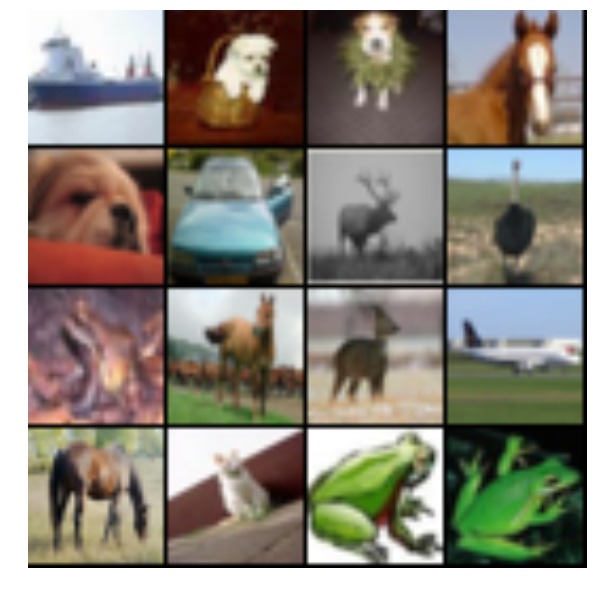

In [4]:
random_idxs = np.random.randint(0,train_X.shape[0], 16)
visualize_data(train_X[random_idxs].transpose(0,2,3,1))

### Define Convolutional Network

### We define a convolutional network that contains:

1. input layer
2. convolutional layer
3. max pooling layer
4. convolutional layer
5. max pooling layer
6. fully-connected layer
7. soft-max layer

We will do it step by step, so that you can extend the architecture of the network later on.

In [5]:
# First we define the symbolic input X and the symbolic target y. We want
# to solve the equation y = C(X) where C is a classifier (convolutional network).
inputs = T.tensor4('X')
targets = T.ivector('y')

In [6]:
# Input layer
network = lasagne.layers.InputLayer(shape=(None,) + train_X.shape[1:],
                                    input_var=inputs)

In [7]:
# Convolutional layer
network = lasagne.layers.Conv2DLayer(
            network, num_filters=32, filter_size=(5, 5),
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())

In [8]:
# Max-pooling layer
network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))

In [9]:
# Convolutional layer
network = lasagne.layers.Conv2DLayer(
            network, num_filters=16, filter_size=(5, 5),
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())

In [10]:
# Max-pooling layer
network = lasagne.layers.MaxPool2DLayer(network, pool_size=(3, 3), stride=(2,2))

In [11]:
# Fully-connected (dense) layer
network = lasagne.layers.DenseLayer(
            network,
            num_units=128,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.Orthogonal())

In [12]:
# Soft-max layer
n_labels = np.max(val_y) + 1
network = lasagne.layers.DenseLayer(
            network, num_units=n_labels,
            nonlinearity=lasagne.nonlinearities.softmax)

###Define Loss function

In [13]:
# First we get the prediction from the last layer and then calculate the
# the loss for each sample and take the mean as final loss.
prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.categorical_crossentropy(prediction, targets)
loss = loss.mean()

###Define learning algorithm

In [14]:
# Create update expressions for training, i.e., how to modify the
# parameters at each training step. Here, we'll use Stochastic Gradient
# Descent (SGD), but Lasagne offers plenty more.
params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.sgd(loss, params, learning_rate=0.01)

test_prediction = lasagne.layers.get_output(network, deterministic=True)
test_loss = lasagne.objectives.categorical_crossentropy(test_prediction, targets)
test_loss = test_loss.mean()
acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), targets),
            dtype=theano.config.floatX)

# Compile a function performing a training step on a mini-batch (by giving
# the updates dictionary) and returning the corresponding training loss:
train_fn = theano.function([inputs, targets], loss, updates=updates)

# Compile a second function computing the validation loss and accuracy:
val_fn = theano.function([inputs, targets], [test_prediction, test_loss, acc])

###Learning

In [15]:
# ### Batch iterator ###
# This is just a simple helper function iterating over training 
# data in mini-batches of a particular size, optionally in random order. 
# It assumes data is available as numpy arrays.
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [ ]:
# The number of epochs specifies the number of passes over the whole training data
num_epochs = 20
curves = {'train_loss': [], 'val_loss': [], 'val_acc': []}
for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data...
    train_err = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(train_X, train_y, 32, shuffle=True):
        inputs, targets = batch
        train_err += train_fn(inputs, targets)
        train_batches += 1

    # ...and a full pass over the validation data
    val_err = 0
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(val_X, val_y, 500, shuffle=False):
        inputs, targets = batch
        preds, err, acc = val_fn(inputs, targets)
        val_err += err
        val_acc += acc
        val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
    print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))
    curves['train_loss'].append(train_err / train_batches)
    curves['val_loss'].append(val_err / val_batches)
    curves['val_acc'].append(val_acc / val_batches)

###Plot learning curves

In [ ]:
plt.plot(zip(curves['train_loss'], curves['val_loss']));

In [ ]:
plt.plot(curves['val_acc']);

###Visualize results

In [ ]:
def visualize_predictions(data, labels, label_to_name={}):
    preds, err, acc = val_fn(data, labels)
    pred_labels = np.argmax(preds, axis=1)
    correct = np.equal(labels, pred_labels)
    per_row = int(0.5 + sqrt(data.shape[0]))
    nr_rows = int(ceil(data.shape[0] / float(per_row)))
    fig, grid = plt.subplots(nr_rows, per_row, figsize=(10,10))  
    cmap = None
    if data.shape[1] == 1:
        cmap="gray"    
    for r in range(nr_rows):
        for c in range(per_row):
            if (r*per_row + c < data.shape[0]):
                grid[r,c].imshow(np.squeeze(data[r*per_row + c].transpose(1,2,0)), cmap=cmap)
                grid[r,c].set_xticklabels([])
                grid[r,c].set_xticklabels([])
                grid[r,c].set_yticklabels([])
                if label_to_name:
                    grid[r,c].set_xlabel("Label = " + str(label_to_name[labels[r*per_row + c]]) + "\nPredicted = " + str(label_to_name[pred_labels[r*per_row + c]]))
                else:
                    grid[r,c].set_xlabel("Label = " + str(labels[r*per_row + c]) + "\nPredicted = " + str(pred_labels[r*per_row + c]))
                for tic in grid[r][c].xaxis.get_major_ticks():
                    tic.tick1On = tic.tick2On = False
                for tic in grid[r][c].yaxis.get_major_ticks():
                    tic.tick1On = tic.tick2On = False
                color = "green"
                if correct[r*per_row + c] == False:
                    color = "red"
                grid[r,c].spines['bottom'].set_color(color)
                grid[r,c].spines['bottom'].set_linewidth(2)
                grid[r,c].spines['top'].set_color(color)
                grid[r,c].spines['top'].set_linewidth(2)
                grid[r,c].spines['left'].set_color(color)
                grid[r,c].spines['left'].set_linewidth(2)
                grid[r,c].spines['right'].set_color(color)
                grid[r,c].spines['right'].set_linewidth(2)
            else :
                grid[r,c].axis('off')
    plt.tight_layout()

In [ ]:
random_incides = np.random.randint(0,val_X.shape[0], 16)
visualize_predictions(val_X[random_incides], val_y[random_incides], label_to_names)